In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **수학과 파이썬 복습**

## **벡터와 행렬**

In [2]:
import numpy as np
x = np.array([1, 2, 3])
print(x.__class__,'\n',x.shape,'\n',x.ndim) # 클래스 이름 표시

<class 'numpy.ndarray'> 
 (3,) 
 1


In [3]:
W = np.array([[1,2,3], [4,5,6]])
print(W.__class__,'\n',W.shape,'\n',W.ndim) # 클래스 이름 표시

<class 'numpy.ndarray'> 
 (2, 3) 
 2


## **행렬의 원소별 연산**

In [4]:
X = np.array([[0,1,2], [3,4,5]])
W + X

array([[ 1,  3,  5],
       [ 7,  9, 11]])

In [5]:
W * X

array([[ 0,  2,  6],
       [12, 20, 30]])

## **브로드캐스트**

In [6]:
A = np.array([[1,2], [3,4]])
A * 10

array([[10, 20],
       [30, 40]])

In [7]:
A = np.array([[1,2], [3,4]])
b = np.array([10, 20])
A * b # 영리하게 확장

array([[10, 40],
       [30, 80]])

## **벡터의 내적과 행렬의 곱**

In [8]:
# 벡터의 내적
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
np.dot(a, b)

32

In [9]:
# 행렬의 곱
A = np.array([[1,2], [3,4]])
B = np.array([[5,6], [7,8]])
np.matmul(A, B)

array([[19, 22],
       [43, 50]])

# **신경망의 추론**

## **신경망 추론 전체 그림**

In [10]:
# 신경망 추론 구현하기

def sigmoid(x):             # 시그모이드 함수 구현
    return 1 / (1 + np.exp(-x))

x = np.random.randn(10, 2)  # 입력(미니배치)
W1 = np.random.randn(2, 4)  # 가중치
b1 = np.random.randn(4)     # 편향
W2 = np.random.randn(4, 3)
b2 = np.random.randn(3)

h = np.matmul(x, W1) + b1   # 은닉층
a = sigmoid(h)              # 활성화
s = np.matmul(a, W2) + b2   # 출력(점수)

## **계층으로 클래스화 및 순전파 구현**

In [11]:
# Sigmoid 계층 구현

class Sigmoid:
    def __init__(self):
        self.params = []

    def forward(self, x):
        return 1 / (1 + np.exp(-x))

In [12]:
# 완전연결계층인 Affine 계층 구현

class Affine:
    def __init__(self, W, b):
        self.params = [W, b]

    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        return out

In [13]:
# TwoLayerNet 구현

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치와 편향 초기화
        W1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = np.random.randn(H, O)
        b2 = np.random.randn(O)

        # 계층 생성
        self.layers = [Affine(W1, b1), Sigmoid(), Affine(W2, b2)]

        # 모든 가중치를 리스트에 모은다.
        self.params = []
        for layer in self.layers:
            self.params += layer.params

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

In [14]:
# 리스트 결합의 예시

a = ['A', 'B']
a += ['C', 'D']
a

['A', 'B', 'C', 'D']

In [15]:
# 신경망의 추론 수행

x = np.random.randn(10, 2)
model = TwoLayerNet(2, 4, 3)
s = model.predict

# **신경망의 학습**

## **계산 그래프**

In [16]:
# Repeat노트 

D, N = 8,7
x = np.random.randn(1, D)               # 입력
y = np.repeat(x, N, axis=0)             # 순전파
dy = np.random.randn(N, D)              # 무작위 기울기
dx = np.sum(dy, axis=0, keepdims=True)  # 역전파

In [17]:
# Sum 노드

D, N = 8, 7
x = np.random.randn(N, D)               # 입력
y = np.sum(x, axis=0, keepdims=True)    # 순전파

dy = np.random.randn(1, D)              # 무작위 기울기
dx = np.repeat(dy, N, axis=0)           # 역전파

In [18]:
# MatMul 노드 계층 구현

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        self.grads[0][...] = dW             # [...]은 넘파이 배열이 가리키는 메모리 위치(메모리 주소)를 고정시킨 다음, 그 위치에 원소들을 덮어쓴다. '깊은 복사' 라고도 한다.
        return dx

## **기울기 도출과 역전파 구현**

In [19]:
# Sigmoid 계층 구현

class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [20]:
# Affine 계층 구현

class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

In [21]:
# Softmax with Loss 계층 구현

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

## **가중치 갱신**

In [22]:
# SGD 구현

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

* SGD를 통한 신경망의 매개변수 갱신 예시(의사코드)

```
model = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch()         # 미니배치 획득
    loss = model.forward(x_batch, t_batch)
    model.backward()
    optimizer.update(model.params, model.grads)
    ...
```

# **신경망으로 문제를 풀다**

## **스파이럴 데이터셋**

In [23]:
my_path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝2/deep-learning-from-scratch-2-master'

import sys
sys.path.append(my_path)
from dataset import spiral
import matplotlib.pyplot as plt

x, t = spiral.load_data()
print('x', x.shape)
print('t', t.shape)

x (300, 2)
t (300, 3)


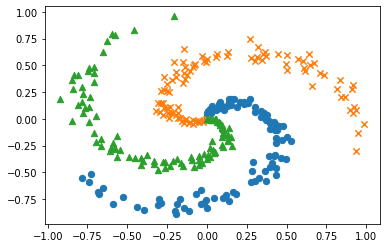

In [24]:
# 산점도 확인

N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

## **신경망 구현**

In [25]:
from common.layers import Affine, Sigmoid, SoftmaxWithLoss

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치와 편향 초기화
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # 계층 생성
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

## **학습용 코드**

In [26]:
# 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# 데이터 읽기, 모델과 옵티마이저 생성
x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # 데이터 뒤섞기
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 기울기를 구해 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        # 정기적으로 학습 경과 출력
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| 에폭 %d |  반복 %d / %d | 손실 %.2f'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0

| 에폭 1 |  반복 10 / 10 | 손실 1.13
| 에폭 2 |  반복 10 / 10 | 손실 1.13
| 에폭 3 |  반복 10 / 10 | 손실 1.12
| 에폭 4 |  반복 10 / 10 | 손실 1.12
| 에폭 5 |  반복 10 / 10 | 손실 1.11
| 에폭 6 |  반복 10 / 10 | 손실 1.14
| 에폭 7 |  반복 10 / 10 | 손실 1.16
| 에폭 8 |  반복 10 / 10 | 손실 1.11
| 에폭 9 |  반복 10 / 10 | 손실 1.12
| 에폭 10 |  반복 10 / 10 | 손실 1.13
| 에폭 11 |  반복 10 / 10 | 손실 1.12
| 에폭 12 |  반복 10 / 10 | 손실 1.11
| 에폭 13 |  반복 10 / 10 | 손실 1.09
| 에폭 14 |  반복 10 / 10 | 손실 1.08
| 에폭 15 |  반복 10 / 10 | 손실 1.04
| 에폭 16 |  반복 10 / 10 | 손실 1.03
| 에폭 17 |  반복 10 / 10 | 손실 0.96
| 에폭 18 |  반복 10 / 10 | 손실 0.92
| 에폭 19 |  반복 10 / 10 | 손실 0.92
| 에폭 20 |  반복 10 / 10 | 손실 0.87
| 에폭 21 |  반복 10 / 10 | 손실 0.85
| 에폭 22 |  반복 10 / 10 | 손실 0.82
| 에폭 23 |  반복 10 / 10 | 손실 0.79
| 에폭 24 |  반복 10 / 10 | 손실 0.78
| 에폭 25 |  반복 10 / 10 | 손실 0.82
| 에폭 26 |  반복 10 / 10 | 손실 0.78
| 에폭 27 |  반복 10 / 10 | 손실 0.76
| 에폭 28 |  반복 10 / 10 | 손실 0.76
| 에폭 29 |  반복 10 / 10 | 손실 0.78
| 에폭 30 |  반복 10 / 10 | 손실 0.75
| 에폭 31 |  반복 10 / 10 | 손실 0.78
| 에폭 32 |  반복 10 

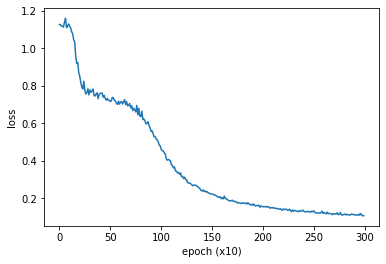

In [27]:
# 학습 결과 plot
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('epoch (x10)')
plt.ylabel('loss')
plt.show()

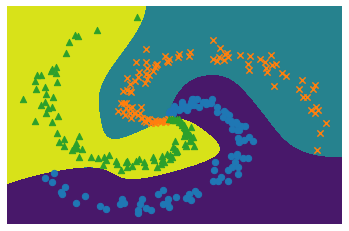

In [28]:
# 경계 영역(decision boundary) plot
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# 산점도 plot
x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

# **계산 고속화**

## **비트 정밀도**

In [29]:
a = np.random.randn(3)
a.dtype

dtype('float64')

In [30]:
# 메모리/계산 속도 관점에서 유리한 32비트

b = np.random.randn(3).astype(np.float32)
b.dtype

dtype('float32')

In [31]:
c = np.random.randn(3).astype('f')
c.dtype

dtype('float32')

## **GPU(쿠파이)**

In [35]:
import cupy as cp # GPU 필요

x = cp.arange(6).reshape(2, 3).astype('f')
x

array([[0., 1., 2.],
       [3., 4., 5.]], dtype=float32)

# **정리**

* **신경망은 입력층, 은닉층(중간층), 출력층을 지닌다.**
* **완전연결계층에 의해 선형 변환이 이뤄지고, 활성화 함수에 의해 비선형 변환이 이뤄진다.**
* **완전연결계층이나 미니배치 처리는 행렬로 모아 한꺼번에 계산할 수 있다.**
* **오차역전파법을 사용하여 신경망의 손실에 관한 기울기를 효율적으로 구할 수 있다.**
* **신경망이 수행하는 처리는 계산 그래프로 시각화할 수 있으며, 순전파와 역전파를 이해하는데 도움이 된다.**
* **신경망의 구성요소들을 '계층'으로 모듈화해두면, 이를 조립하여 신경망을 쉽게 구성할 수 있다.**
* **신경망 고속화에는 GPU를 이용한 병렬 계산과 데이터의 비트 정밀도가 중요하다.**